# Linear Discriminant Analysis

Let $\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n\in\mathbb{R}^m$ be observation with known class lables $z_1,\ldots,z_n$.
Then the aim of the Linear Discrimint Analysis (LDA) is to find a linear projection $\pi:\mathbb{R}^m\to\mathbb{R}^k$ so that individual classes are maximally separated.
What exactly does it mean will be discussed below.

As we use three-dimensional data for more elaborate examples, we also use the package `ipyvolume` for making three-dimensional plots interactive. Further details about this package can be obtained from the following sources:

* [Ipyvolume documentation](https://ipyvolume.readthedocs.io/en/latest/)
* [Maarten Breddels, Interactive 3D Visualization in Jupyter, SciPy 2018, Youtube](https://www.youtube.com/watch?v=hOKa8klJPyo)
* [Maarten Breddels, Interactive 3D Visualization in Jupyter, SciPy 2018, Jupyter Notebook](https://github.com/maartenbreddels/talk-ipyvolume-scipy2018/blob/master/ipyvolume-presentation.ipynb)



In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn

from pandas import Series
from pandas import DataFrame
from typing import List,Tuple

from pandas import Categorical
from pandas.api.types import CategoricalDtype

from tqdm import tnrange#, tqdm_notebook
from plotnine import *

from scipy.stats import multivariate_normal
from numpy.linalg import norm
from numpy import sin, cos 
from numpy.linalg import eig

# Tools for 3D visualisation
import ipyvolume as ipv
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle

# Local imports
from common import *
from convenience import *

## I.  Spherical normal distributions

Consider the case where datapoints with the same label $j\in\{1,\ldots,\ell\}$ come from a multivariate normal distribution $\mathcal{N}(\boldsymbol{\mu}_j, \boldsymbol{\mathrm{I}})$. 
If we project the data down to one-dimensional subspaces, we can get quite different results – the datapoints can be distinctly grouped by their respective class labels but they could also be mixed.

In [2]:
# Dataset size
n = 1000

# Cluster parameters
Theta = (DataFrame({'x1': [-1.5, 1.5], 'x2': [0.0, 0.0], 
                    'lambda': [0.5, 0.5], 'z': ['A', 'B']})
         .set_index('z', drop=False))

# Dataset generation
df = (DataFrame(multivariate_normal(cov=np.identity(2)).rvs(n),columns=['x1', 'x2'])
      .assign(z = np.random.choice(Theta['z'], p=Theta['lambda'], size = n))
      .assign(x1 = lambda df:  df['x1'] + Theta.loc[df['z'], 'x1'].values)
      .assign(x2 = lambda df:  df['x2'] + Theta.loc[df['z'], 'x2'].values))

mdisplay([Theta,head(df)], ['Model parameters', 'Simulated data'])

Model parameters Simulated data 
 
 
 x1 
 x2 
 lambda 
 z 
 
 
 
 
 -1.5 
 0.0 
 0.5 
 A 
 
 
 1.5 
 0.0 
 0.5 
 B 
 
 
 
 
 
 x1 
 x2 
 z 
 
 
 
 
 1.337752 
 0.008435 
 B 
 
 
 -0.106113 
 -0.833480 
 B 
 
 
 -1.035923 
 -0.932676 
 A 
 
 
 0.566062 
 0.831222 
 B 
 
 
 1.182192 
 0.049725 
 B

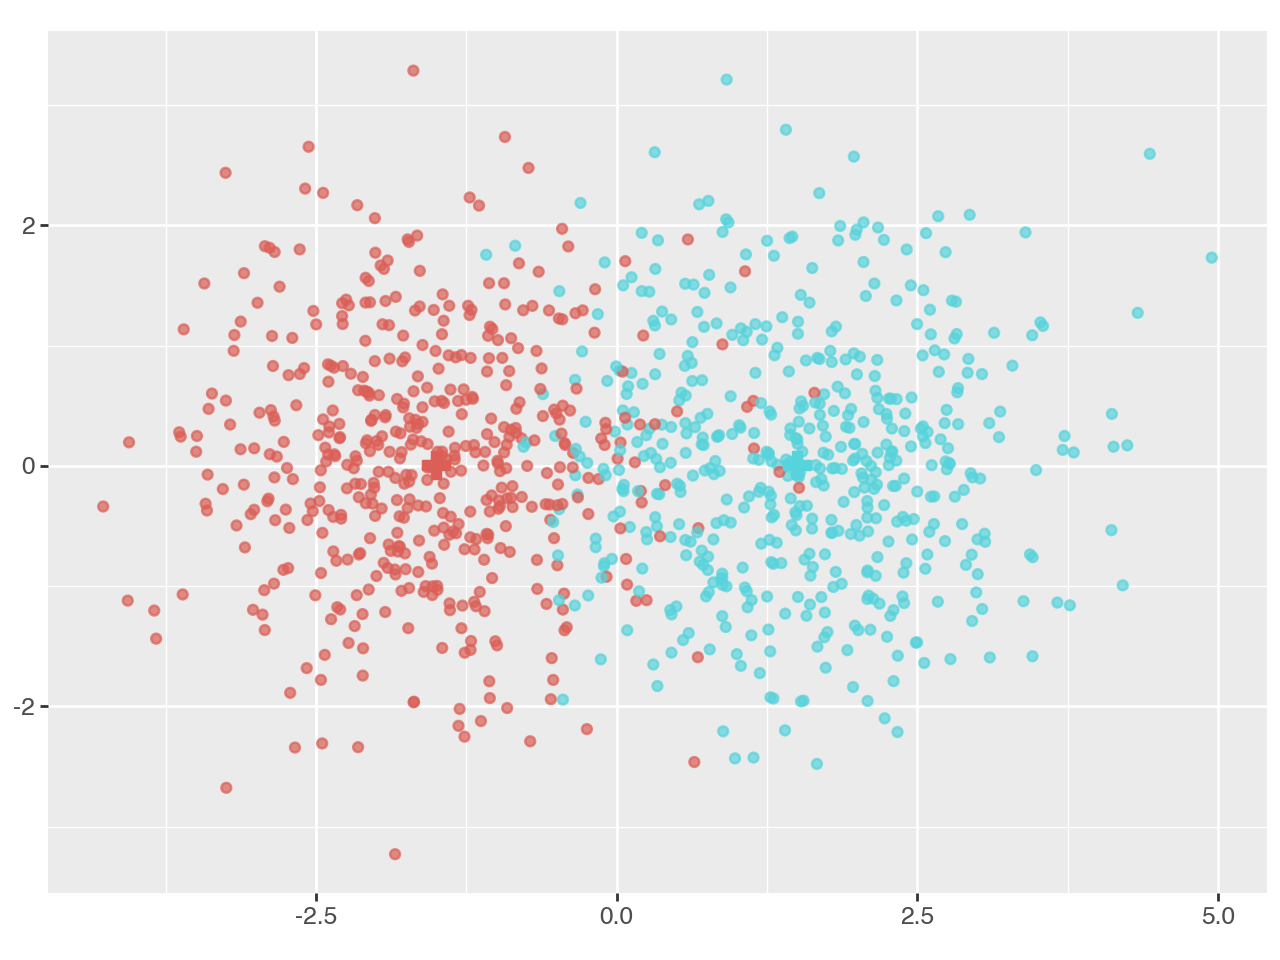

In [3]:
p = ggplot(df)
p = p + geom_point(aes(x = 'x1', y = 'x2', color = 'z'), alpha = 0.7)
p = p + geom_point(aes(x = 'x1', y = 'x2', color = 'z'), data = Theta, shape = 'P', fill='black', size=5, )
p = p + scale_color_discrete(name='', guide=None)
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
p = p + coord_fixed()
p.save('simplified_lda_setup_i.pdf', path='results', height=6, width=12, verbose=False)
display(p)

## II. Projections to one-dimensional subspaces

Let us take four directions $\boldsymbol{w}_1,\ldots,\boldsymbol{w}_4$ onto which we could project the data.
For any direction $\boldsymbol{w}$ the corresponding projections will be $y_i=\boldsymbol{w}^T\boldsymbol{x}_i$. 

### Unit vectors defining projections

,x1,x2
0,0.000000,1.000000
1,1.000000,0.000000
2,0.707107,0.707107
3,-0.768490,-0.639862


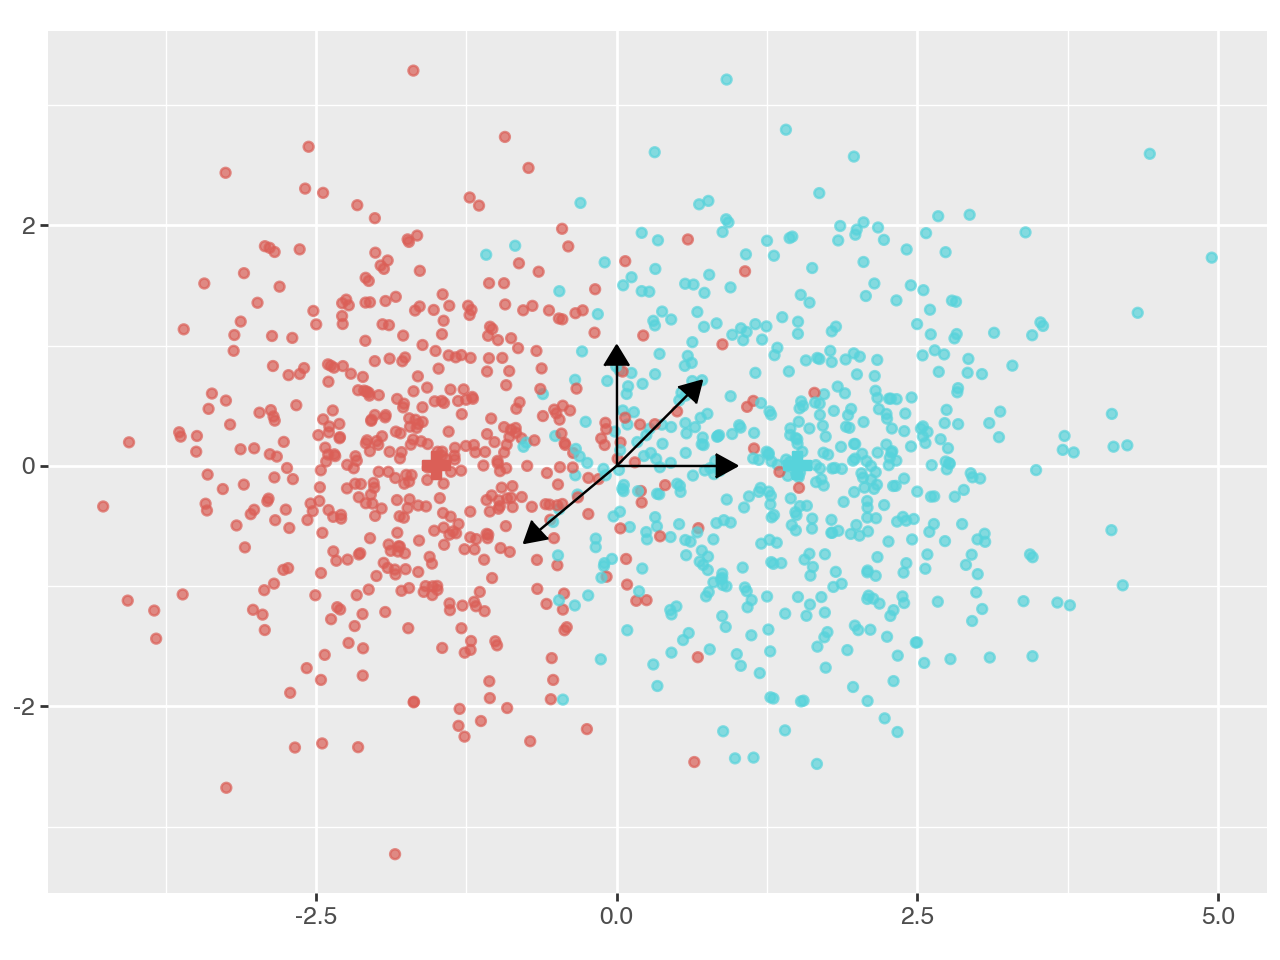

In [4]:
W = (DataFrame([(0,1), (1,0), (1,1), multivariate_normal(cov=np.identity(2)).rvs(1)], columns = ['x1', 'x2'])
     .assign(d  = lambda df: np.sqrt(df['x1']**2 + df['x2']**2))
     .assign(x1 = lambda df: df['x1']/df['d'])
     .assign(x2 = lambda df: df['x2']/df['d'])
     [['x1','x2']])
     
display(W)

p = ggplot(df)
p = p + geom_point(aes(x = 'x1', y = 'x2', color = 'z'), alpha = 0.7)
p = p + geom_point(aes(x = 'x1', y = 'x2', color = 'z'), data = Theta, shape = 'P', fill='black', size=5, )
p = p + scale_color_discrete(name='', guide=None)
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
p = p + coord_fixed()
p = p + geom_segment(aes(xend = 'x1', yend='x2'), data = W, x=0, y=0, arrow=arrow(type = 'closed', length=0.1))
p.save('simplified_lda_setup_ii.pdf', path='results', height=6, width=12, verbose=False)
display(p)

### Corresponding projections and their visualisations

,z,p1,p2,p3,p4
0,B,0.008435,1.337752,0.951898,-1.033446
1,B,-0.833480,-0.106113,-0.664393,0.614859
2,A,-0.932676,-1.035923,-1.392010,1.392881
3,B,0.831222,0.566062,0.988029,-0.966880
4,B,0.049725,1.182192,0.871097,-0.940320


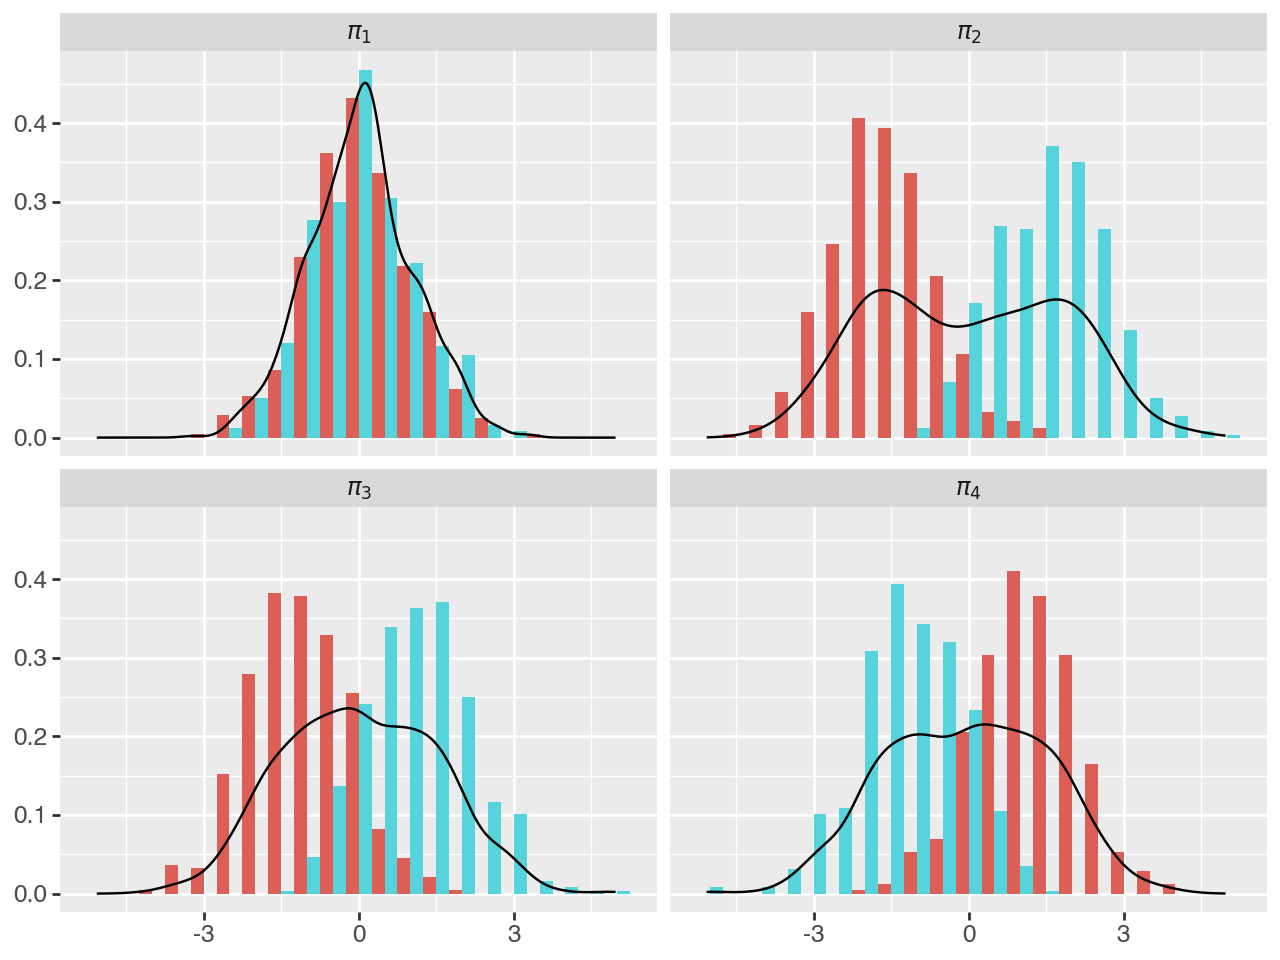

In [5]:
proj = (df[['z']]
      .assign(p1 = df[['x1', 'x2']].dot(W.loc[0, :]))
      .assign(p2 = df[['x1', 'x2']].dot(W.loc[1, :]))
      .assign(p3 = df[['x1', 'x2']].dot(W.loc[2, :]))
      .assign(p4 = df[['x1', 'x2']].dot(W.loc[3, :])))

display(head(proj))

tmp = (pd.melt(proj, id_vars=['z'], var_name='projector', value_name='y')
       .assign(projector =  lambda df: df['projector'].map(lambda x:'$\pi_{}$'.format(x[1]))))


p = ggplot(tmp)
p = p + geom_histogram(aes(x = 'y', y = '..density..', fill ='z'), binwidth=0.5, position='dodge')
p = p + stat_density(aes(x = 'y'), geom = "line", position = "identity", group = 'z') 
p = p + facet_wrap(['projector'])
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
p = p + scale_fill_discrete(name='', guide=None)
p.save('simplified_lda_setup_iii.pdf', path='results', height=6, width=12, verbose=False)
display(p)

## III. Optimal projection direction for one-dimensional subspace

As different directions lead to different separations, we can ask what is the most separating direction. 
For that we propose two hypotheses:

* The projected data $y_1,\ldots, y_n$ comes from a normal distribution $\mathcal{N}(\bar{y}, 1)$.
* The projected data  $y_1,\ldots, y_n$ comes from a mixture of normal distributions $\mathcal{N}(\bar{y}_1,1),\ldots \mathcal{N}(\bar{y}_\ell,1)$.

As we know the cluster label for each datapoint, we can compute

\begin{align*}
p[y_i|\mathcal{H}_0]&=\frac{1}{\sqrt{2\pi}}\cdot \exp\Bigl(-\frac{1}{2}(y_i-\bar{y})^2\Bigl)\\
p[y_i|\mathcal{H}_1]&=\frac{1}{\sqrt{2\pi}}\cdot \exp\Bigl(-\frac{1}{2}(y_i-\bar{y}_{z_i})^2\Bigl)
\end{align*}

from which we get

\begin{align*}
\log\frac{p[y_1,\ldots,y_n|\mathcal{H}_1]}{p[y_1,\ldots,y_n|\mathcal{H}_0]}= 
\frac{1}{2}\cdot\sum_{i=1}^n (y_i-\bar{y})^2
-\frac{1}{2}\cdot \sum_{i=1}^n (y_i-\bar{y}_{z_i})^2\,.
\end{align*}

If we assign uninformative prior to both models then the Bayes factor

\begin{align*}
\frac{\Pr[\mathcal{H}_1|y_1,\ldots,y_n]}{\Pr[\mathcal{H}_0|y_1,\ldots,y_n]}= 
\frac{p[y_1,\ldots,y_n|\mathcal{H}_1]}{p[y_1,\ldots,y_n|\mathcal{H}_0]}
\end{align*}

shows how many times the hypothesis $\mathcal{H}_1$ is more probable than $\mathcal{H}_0$.
Under our belief $\mathcal{H}_1$ is the correct model and thus it makes sense to consider the projection direction that maximises the Bayes factor, i.e., we need to solve

\begin{align*}
F=\sum_{i=1}^n (y_i-\bar{y})^2
-\sum_{i=1}^n (y_i-\bar{y}_{z_i})^2\to \max\,.
\end{align*}

Note that maximum likelihood estimates for the cluster centers are

\begin{align*}
\bar{y}&=\frac{1}{n}\cdot\sum_{i=1}^n y_i\\
\bar{y}_j&=\frac{1}{|\mathcal{I}_j|}\cdot\sum_{i\in\mathcal{I}_j}^n y_j\\
\end{align*}

where $\mathcal{I}_j=\{i: z_i=j\}$. This allows us to express

\begin{align*}
\sum_{i=1}^n (y_i-\bar{y})^2&=\sum_{i=1}^n (y_i-\bar{y}_{z_i}+\bar{y}_{z_i}-\bar{y})^2\\
&=\sum_{i=1}^n (y_i-\bar{y}_{z_i})^2 +2\cdot \sum_{i=1}^n (y_i-\bar{y}_{z_i})(\bar{y}_{z_i}-\bar{y}_i)+\sum_{i=1}^n (\bar{y}_{z_i}-\bar{y})^2\\
&=\sum_{i=1}^n (y_i-\bar{y}_{z_i})^2 +\sum_{i=1}^n (\bar{y}_{z_i}-\bar{y})^2
\end{align*}

and thus the maximisation task becomes

\begin{align*}
F=\sum_{i=1}^n (\bar{y}_{z_i}-\bar{y})^2\to \max\,.
\end{align*}

The latter can be further simplified to 

\begin{align*}
\sum_{j=1}^\ell \frac{|\mathcal{I}_j|}{n}(\bar{y}_{j}-\bar{y})^2\to \max\,.
\end{align*}

For centered data $\bar{y}=0$ and we must maximize the weighted sum of cluster center distance squares.

### Direct computation and optimised computation of Bayes factors

In [6]:
ybar = pd.concat([DataFrame(proj.iloc[:, 1:].mean(), columns = ['*']).T, proj.groupby('z').mean()])
display(ybar)

,p1,p2,p3,p4
*,0.040634,0.006297,0.033185,-0.030839
A,0.048307,-1.578596,-1.082077,1.182225
B,0.033349,1.510863,1.091923,-1.182422


Likelihood for the null hypothesis $\mathcal{H}_0$:

In [7]:
logpr_h0 = DataFrame(DataFrame({'p1': stats.norm(loc = ybar.loc['*', 'p1']).logpdf(proj['p1']),
                                'p2': stats.norm(loc = ybar.loc['*', 'p2']).logpdf(proj['p2']),
                                'p3': stats.norm(loc = ybar.loc['*', 'p3']).logpdf(proj['p3']),
                                'p4': stats.norm(loc = ybar.loc['*', 'p4']).logpdf(proj['p4'])
                               }).sum()).T

display(logpr_h0)

,p1,p2,p3,p4
0,-1421.176647,-2629.331891,-2016.50936,-2126.084918


Likelihood for the alternative hypothesis $\mathcal{H}_1$:

In [8]:
logpr_h1 = DataFrame({'p1': [stats.norm(loc = ybar.loc['A', 'p1']).logpdf(proj.loc[proj['z'] == 'A', 'p1']).sum() + 
                             stats.norm(loc = ybar.loc['B', 'p1']).logpdf(proj.loc[proj['z'] == 'B', 'p1']).sum()],
                      'p2': [stats.norm(loc = ybar.loc['A', 'p2']).logpdf(proj.loc[proj['z'] == 'A', 'p2']).sum() +
                             stats.norm(loc = ybar.loc['B', 'p2']).logpdf(proj.loc[proj['z'] == 'B', 'p2']).sum()],    
                      'p3': [stats.norm(loc = ybar.loc['A', 'p3']).logpdf(proj.loc[proj['z'] == 'A', 'p3']).sum() +
                             stats.norm(loc = ybar.loc['B', 'p3']).logpdf(proj.loc[proj['z'] == 'B', 'p3']).sum()],    
                      'p4': [stats.norm(loc = ybar.loc['A', 'p4']).logpdf(proj.loc[proj['z'] == 'A', 'p4']).sum() +
                             stats.norm(loc = ybar.loc['B', 'p4']).logpdf(proj.loc[proj['z'] == 'B', 'p4']).sum()]
                     })                
display(logpr_h1)

,p1,p2,p3,p4
0,-1421.148699,-1437.044027,-1426.124023,-1427.61295


Bayes factors to selected directions indicate that the best projection is $\pi_2$ and the worst projection is $\pi_1$ as expected.

In [9]:
display(logpr_h1-logpr_h0)

,p1,p2,p3,p4
0,0.027948,1192.287864,590.385337,698.471968


Optimised computation of Bayes factors leads to the same answer as expected:

In [10]:
DataFrame(0.5*((ybar.loc[proj['z']] - ybar.loc['*'])**2).sum()).T

,p1,p2,p3,p4
0,0.027948,1192.287864,590.385337,698.471968


## IV. Optimal projection direction for k-dimensional subspaces

Let $\pi:\mathbb{R}\to\mathbb{R}$ be an orthoprojector specified by an $m\times k$ matrix $\boldsymbol{\mathrm W}$, that is $\boldsymbol{\mathrm W}^T\boldsymbol{\mathrm W}=\boldsymbol{\mathrm I}$. Then the projector converts a spherical normal distribution into a spherical normal distribution.
Indeed, let $\boldsymbol{y}=\boldsymbol{\mathrm W}^T\boldsymbol{x}$ be a random variable for $\boldsymbol{x}\sim\mathcal{N}(\boldsymbol{0},\boldsymbol{\mathrm{I}})$. Then we get the desired conformation

\begin{align*}
\boldsymbol{\mathrm{Cov}}[\boldsymbol{y}]=\boldsymbol{\mathrm{E}}[\boldsymbol{y}\boldsymbol{y}^T]=
\boldsymbol{\mathrm{E}}[\boldsymbol{\mathrm W}^T\boldsymbol{x}\boldsymbol{x}^T\boldsymbol{\mathrm W}]=
\boldsymbol{\mathrm W}^T\boldsymbol{\mathrm{E}}[\boldsymbol{x}\boldsymbol{x}^T]\boldsymbol{\mathrm W}=
\boldsymbol{\mathrm W}^T\boldsymbol{\mathrm W}=\boldsymbol{\mathrm{I}}\,.
\end{align*}

In brief, the orthoprojector can change only the centerpoint of the distribution. 
Hence, we can still propose two hypotheses:

* The projected data $\boldsymbol{y}_1,\ldots, \boldsymbol{y}_n$ comes from a normal distribution $\mathcal{N}(\bar{\smash{\boldsymbol{y}}}, \boldsymbol{\mathrm{I}})$.
* The projected data  $\boldsymbol{y}_1,\ldots, \boldsymbol{y}_n$ comes from a mixture of normal distributions $\mathcal{N}(\bar{\smash{\boldsymbol{y}}}_1,\boldsymbol{\mathrm{I}}),\ldots \mathcal{N}(\bar{\smash{\boldsymbol{y}}}_\ell,\boldsymbol{\mathrm{I}})$.

As we know the cluster label for each datapoint, we can compute

\begin{align*}
p[\boldsymbol{y}_i|\mathcal{H}_0]&=\frac{1}{(2\pi)^{k/2}}\cdot \exp\Bigl(-\frac{1}{2}\cdot(\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}})^T(\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}})\Bigl)\\
p[\boldsymbol{y}_i|\mathcal{H}_1]&=\frac{1}{(2\pi)^{k/2}}\cdot \exp\Bigl(-\frac{1}{2}\cdot(\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}}_{z_i})^T(\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}}_{z_i})\Bigl)
\end{align*}

from which we get

\begin{align*}
\log\frac{p[\boldsymbol{y}_1,\ldots,\boldsymbol{y}_n|\mathcal{H}_1]}{p[\boldsymbol{y}_1,\ldots,\boldsymbol{y}_n|\mathcal{H}_0]}= 
\frac{1}{2}\cdot\sum_{i=1}^n (\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}})^T(\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}})
-\frac{1}{2}\cdot \sum_{i=1}^n (\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}}_{z_i})^T(\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}}_{z_i})\,.
\end{align*}

If we assign uniformative prior to both models then the Bayes factor

\begin{align*}
\frac{\Pr[\mathcal{H}_1|\boldsymbol{y}_1,\ldots,\boldsymbol{y}_n]}
{\Pr[\mathcal{H}_0|\boldsymbol{y}_1,\ldots,\boldsymbol{y}_n]}= 
\frac{p[\boldsymbol{y}_1,\ldots,\boldsymbol{y}_n|\mathcal{H}_1]}
{p[\boldsymbol{y}_1,\ldots,\boldsymbol{y}_n|\mathcal{H}_0]}
\end{align*}

shows how many times the hypothesis $\mathcal{H}_1$ is more probable than the null hypothesis $\mathcal{H}_0$.
Under our belief $\mathcal{H}_1$ is the correct model and thus it makes sense to consider an orthoprojector that maximises the Bayes factor, i.e., we need to solve

\begin{align*}
\sum_{i=1}^n (\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}})^T(\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}})
-\sum_{i=1}^n (\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}}_{z_i})^T(\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}}_{z_i})\to \max\,.
\end{align*}

Note that maximum likelihood estimates for the cluster centers are

\begin{align*}
\bar{\smash{\boldsymbol{y}}}&=\frac{1}{n}\cdot\sum_{i=1}^n \boldsymbol{y}_i\\
\bar{\smash{\boldsymbol{y}}}_j&=\frac{1}{|\mathcal{I}_j|}\cdot\sum_{i\in\mathcal{I}_j}^n \boldsymbol{y}_j\\
\end{align*}

where $\mathcal{I}_j=\{i: z_i=j\}$. This allows us to express

\begin{align*}
\sum_{i=1}^n (\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}})^T(\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}})
&=\sum_{i=1}^n (\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}}_{z_i})^T (\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}}_{z_i})
+\sum_{i=1}^n (\bar{\smash{\boldsymbol{y}}}_{z_i}-\bar{\smash{\boldsymbol{y}}})^T (\bar{\smash{\boldsymbol{y}}}_{z_i}-\bar{\smash{\boldsymbol{y}}})
\end{align*}

and thus the maximisation task becomes

\begin{align*}
F=\sum_{i=1}^n (\bar{\smash{\boldsymbol{y}}}_{z_i}-\bar{\smash{\boldsymbol{y}}})^T (\bar{\smash{\boldsymbol{y}}}_{z_i}-\bar{\smash{\boldsymbol{y}}})\to \max\,.
\end{align*}

For centered data we are looking a projector that maximises the weighted distance squares of the clusters.

### Advanced example in three-dimensional space

To explain LDA projection with more than one dimension we need at least three classes and three dimensional observations. To make our life easier we consider a symmetrical placement of cluster centers on the $xy$-plane. 

In [11]:
# Dataset size
n = 1000
d = 2

# Cluster parameters
Theta3 = (DataFrame({'x1': [d*sin(2*np.pi/3), d*sin(4*np.pi/3), d*sin(6*np.pi/3)], 
                     'x2': [d*cos(2*np.pi/3), d*cos(4*np.pi/3), d*cos(6*np.pi/3)], 
                     'x3': [0, 0, 0], 'lambda': [1/3, 1/3, 1/3], 
                     'z': ['A', 'B', 'C']})
         .set_index('z', drop=False))

# Dataset generation
df3 = (DataFrame(multivariate_normal(cov=np.identity(3)).rvs(n), columns=['x1', 'x2', 'x3'])
      .assign(z = np.random.choice(Theta3['z'], p=Theta3['lambda'], size = n))
      .assign(x1 = lambda df:  df['x1'] + Theta3.loc[df['z'], 'x1'].values)
      .assign(x2 = lambda df:  df['x2'] + Theta3.loc[df['z'], 'x2'].values)
      .assign(x3 = lambda df:  df['x3'] + Theta3.loc[df['z'], 'x3'].values)
      )

mdisplay([Theta3,head(df3)], ['Model parameters', 'Simulated data'])

Model parameters Simulated data 
 
 
 x1 
 x2 
 x3 
 lambda 
 z 
 
 
 
 
 1.732051e+00 
 -1.0 
 0 
 0.333333 
 A 
 
 
 -1.732051e+00 
 -1.0 
 0 
 0.333333 
 B 
 
 
 -4.898587e-16 
 2.0 
 0 
 0.333333 
 C 
 
 
 
 
 
 x1 
 x2 
 x3 
 z 
 
 
 
 
 2.024098 
 2.438784 
 -0.375616 
 C 
 
 
 -1.997844 
 -0.032030 
 -0.444325 
 B 
 
 
 1.038417 
 2.558643 
 0.912094 
 C 
 
 
 1.278327 
 -0.393940 
 0.550914 
 A 
 
 
 0.782794 
 1.673793 
 -1.914592 
 C

In [12]:
# RGB colors for different class labels
color3 = np.zeros([n, 3])
color3[df3['z']=='A', 0] = 1
color3[df3['z']=='B', 1] = 1
color3[df3['z']=='C', 2] = 1

# The figure itself
fig = ipv.figure()
scatter = ipv.scatter(df3.loc[:, 'x1'].values, df3.loc[:, 'x2'].values, df3.loc[:, 'x3'].values,
                      color = color3, s = 0.5, marker='sphere')
ipv.squarelim()
ipv.show()

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

Projection on $xy$-plane versus projection on $xz$-plane. 

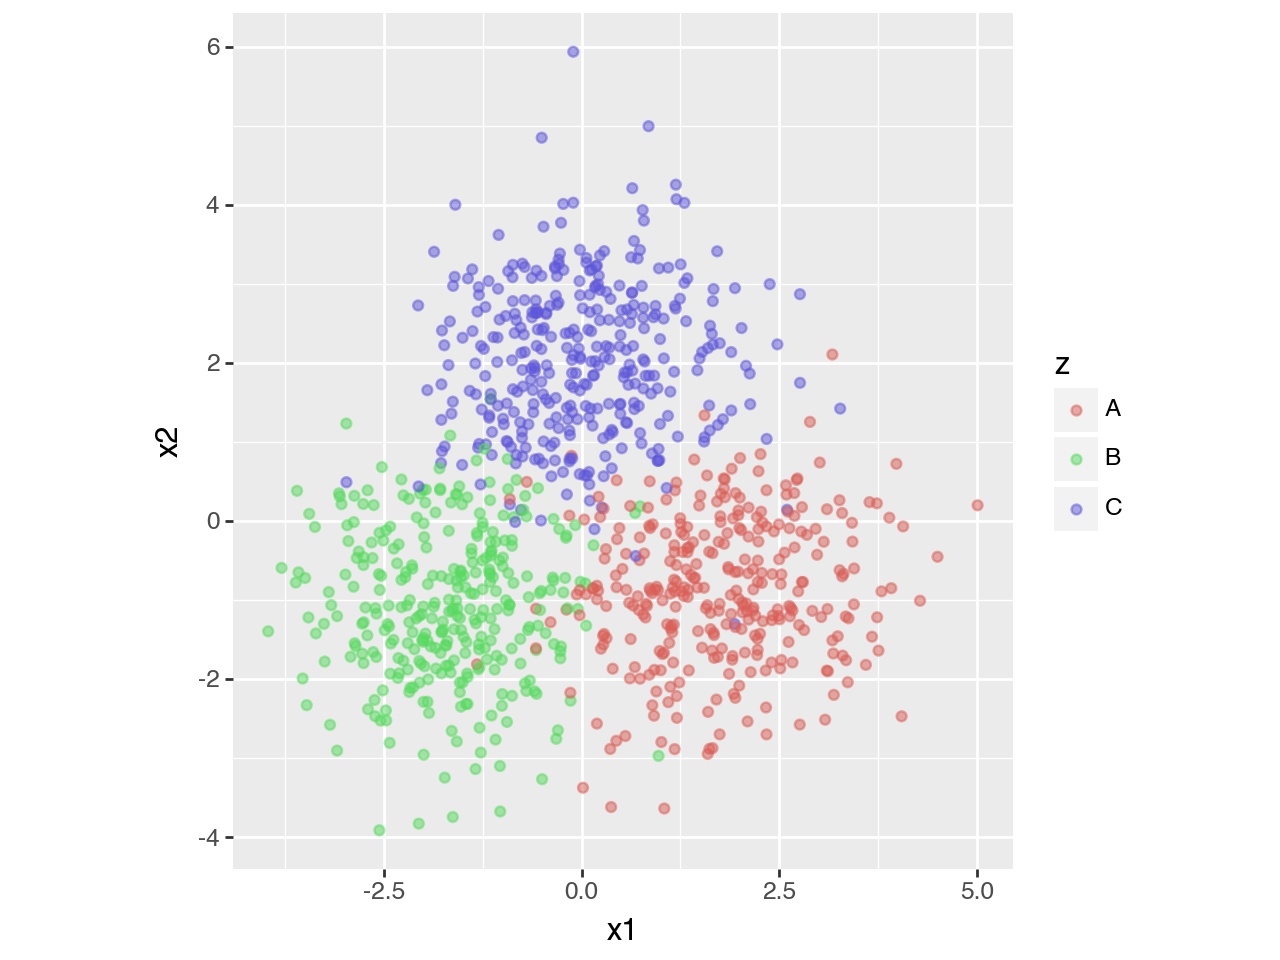

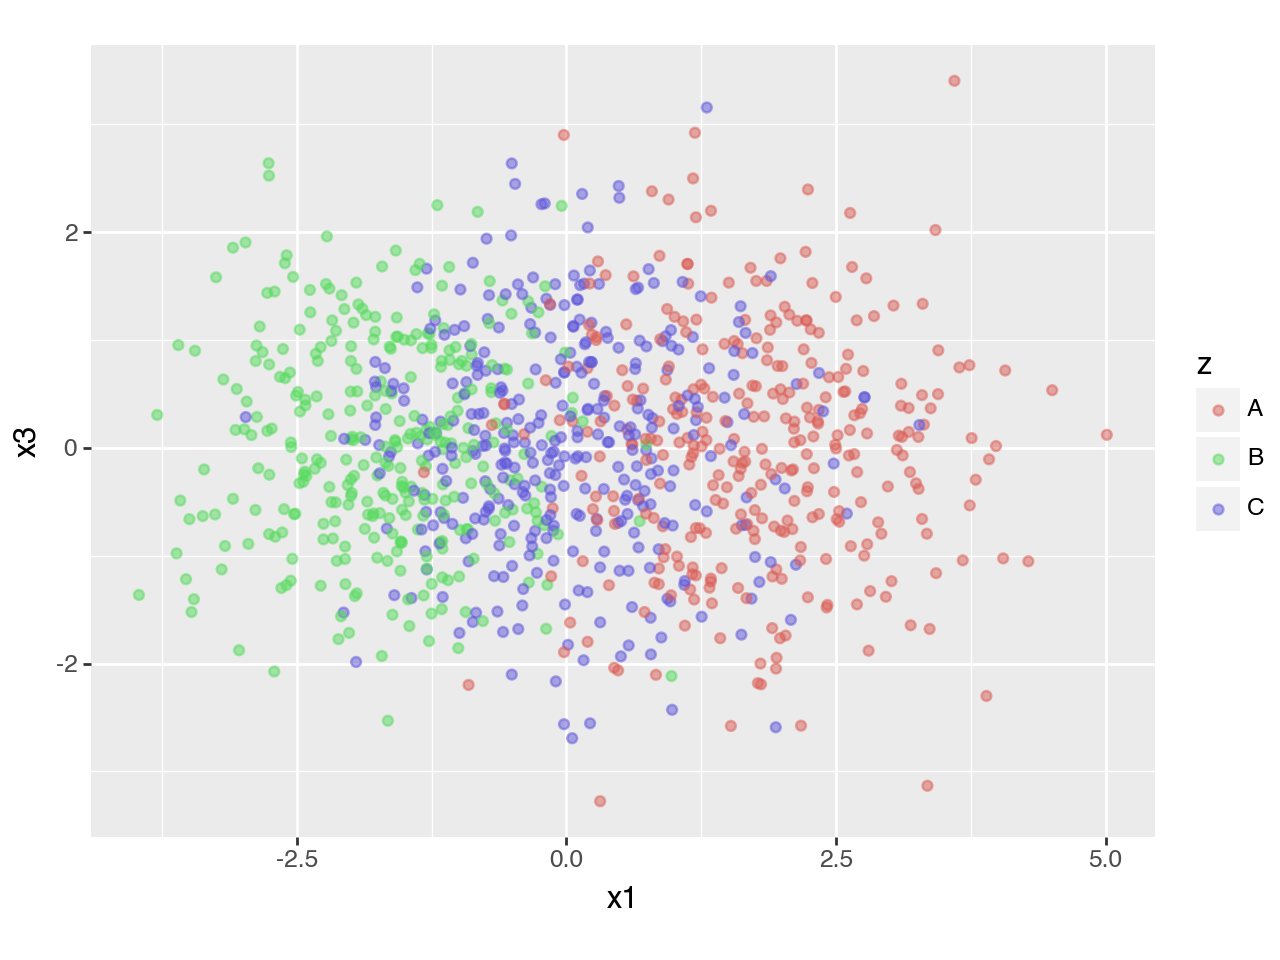

In [13]:
p = ggplot(df3)
p = p + geom_point(aes(x = 'x1', y = 'x2', color='z'), alpha=0.5)
p = p + coord_fixed(ratio=1)
display(p)

p = ggplot(df3)
p = p + geom_point(aes(x = 'x1', y = 'x3', color='z'), alpha=0.5)
p = p + coord_fixed(ratio=1)
display(p)

## V. Closed form solution for the optimisation task

Recall that our goal is to find an orthoprojector defined by $\boldsymbol{\mathrm{W}}$ such that

\begin{align*}
F=\sum_{i=1}^n (\bar{\smash{\boldsymbol{y}}}_{z_i}-\bar{\smash{\boldsymbol{y}}})^T (\bar{\smash{\boldsymbol{y}}}_{z_i}-\bar{\smash{\boldsymbol{y}}})\to \max\,.
\end{align*}

Let 

\begin{align*}
\boldsymbol{\mu}&=\frac{1}{n}\cdot\sum_{i=1}^n \boldsymbol{x}_i
\end{align*}

denote the center point for the entire data and

\begin{align*}
\boldsymbol{\mu}_j&=\frac{1}{|\mathcal{I}_j|}\cdot\sum_{i\in\mathcal{I}_j}^n \boldsymbol{x}_j\\
\end{align*}

center points for the clusters. 
Then due to linearity $\bar{\smash{\boldsymbol{y}}}=\boldsymbol{\mathrm{W}}^T \boldsymbol{\mu}$ and 
$\bar{\smash{\boldsymbol{y}}}_j=\boldsymbol{\mathrm{W}}^T \boldsymbol{\mu}_j$ and we can rewrite the quantity to be maximised in a different form:

\begin{align*}
F&=\sum_{i=1}^n (\boldsymbol{\mathrm{W}}^T\boldsymbol{\mu}_{z_i}-\boldsymbol{\mathrm{W}}^T \boldsymbol{\mu})^T (\boldsymbol{\mathrm{W}}^T\boldsymbol{\mu}_{z_i}-\boldsymbol{\mathrm{W}}^T \boldsymbol{\mu})\\
&=\sum_{i=1}^n (\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})^T \boldsymbol{\mathrm{W}}\boldsymbol{\mathrm{W}}^T (\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})\\
&= \sum_{i=1}^n \sum_{j=1}^k(\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})^T \boldsymbol{w}_j\boldsymbol{w}_j^T (\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})\\
&= \sum_{i=1}^n \sum_{j=1}^k \boldsymbol{w}_j^T(\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})(\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})^T\boldsymbol{w}_j\\
&=  \sum_{j=1}^k \boldsymbol{w}_j^T\Bigl( \sum_{i=1}^n(\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})(\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})^T\Bigr)\boldsymbol{w}_j\,.
\end{align*}

Now let 
\begin{align*}
\boldsymbol{\mathrm{S}}_B=\sum_{i=1}^n(\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})(\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})^T 
\end{align*}

be the between-cluster scatter matrix. Then we can recast the maximisation task as

\begin{align*}
\sum_{j=1}^k \boldsymbol{w}_j^T\boldsymbol{\mathrm S}_B\boldsymbol{w}_j \to \max
\end{align*}
where $\boldsymbol{w}_1,\ldots,\boldsymbol{w}_k$ are orthogonal vectors. 
As the scatter matrix is positive definite there exist an orthogonal basis of eigenvectors $\boldsymbol{w}_1,\ldots,\boldsymbol{w}_m$ with corresponding eigenvalues $\lambda_1\geq \ldots\geq\lambda_m$. 
The sum is maximised only if we take the first $k$ eigenvectors.

### Three-dimensional example continued

Let us find the solution in closed form. For that we need to 
* compute the scatter matrix
* find its first two eigenvectors. 

In [14]:
# Compute necessary means
mu3 = pd.concat([DataFrame(df3.iloc[:, :3].mean(), columns=['*']).T,df3.groupby('z').mean()])
display(mu3)

# Compute scatter matrix
delta=mu3.loc[df3['z']].sub(mu3.loc['*'], axis=1)
SB = delta.T.dot(delta)
display(SB)

# Find eigenvectors
eigenValues, eigenVectors = eig(SB)
idx = np.argsort(-eigenValues) # sort decreasing
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]

W3 = DataFrame(eigenVectors, columns=['LDA1', 'LDA2', 'LDA3'], index=['x1', 'x2', 'x3'])
display(W3)

,x1,x2,x3
*,0.020409,0.074614,0.015084
A,1.737405,-0.892252,-0.007657
B,-1.686313,-1.084112,0.027642
C,0.001226,2.030580,0.024557


,x1,x2,x3
x1,1899.120456,86.030859,-19.676808
x2,86.030859,2084.176374,8.968325
x3,-19.676808,8.968325,0.250603


,LDA1,LDA2,LDA3
x1,0.365777,-0.930642,0.010575
x2,0.930702,0.365747,-0.004739
x3,0.000543,0.011576,0.999933


### Corresponding 3D visualisation

In [15]:
# Lets make a coordinate grid
a = np.arange(-5, 5)
U, V = np.meshgrid(a, a)

# Lets compute XYZ coordinates of the plane 
X = U.flatten() * W3.loc['x1', 'LDA1'] + V.flatten() * W3.loc['x1', 'LDA2']
Y = U.flatten() * W3.loc['x2', 'LDA1'] + V.flatten() * W3.loc['x2', 'LDA2']
Z = U.flatten() * W3.loc['x3', 'LDA1'] + V.flatten() * W3.loc['x3', 'LDA2']

# Lets move the plane to the center of gravity 
X = X + mu3.loc['*', 'x1']
Y = Y + mu3.loc['*', 'x2']
Z = Z + mu3.loc['*', 'x3']

# Lets reshape the data for plotting the fireframe
X = X.reshape(U.shape)
Y = Y.reshape(U.shape)
Z = Z.reshape(U.shape)


ipv.figure()
scatter = ipv.scatter(df3.loc[:, 'x1'].values, df3.loc[:, 'x2'].values, df3.loc[:, 'x3'].values,
                      color = color3, s = 0.5, marker='sphere')
ipv.squarelim()
ipv.plot_wireframe(X, Y, Z, color="brown")
ipv.show()

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

### Corresponding two-dimesnional data projection

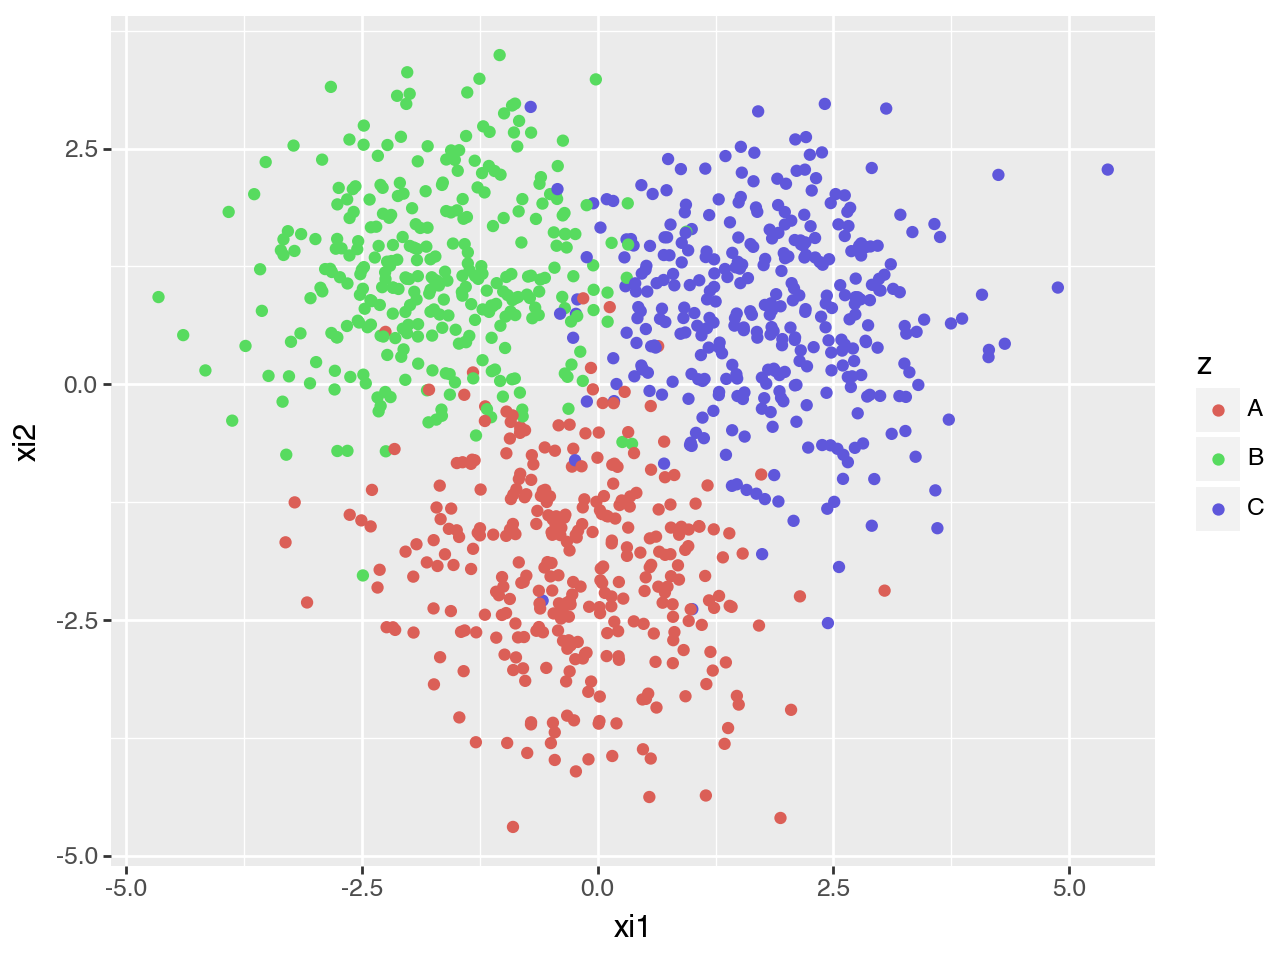

In [16]:
df3 = (df3
       .assign(xi1 = lambda df: df[['x1', 'x2', 'x3']].sub(mu3.loc['*']).dot(W3['LDA1']))
       .assign(xi2 = lambda df: df[['x1', 'x2', 'x3']].sub(mu3.loc['*']).dot(W3['LDA2']))
      )


p = ggplot(df3)
p = p + geom_point(aes(x='xi1', y='xi2', color='z'))
p = p + coord_fixed(ratio=1)
display(p)

### The difference between projection and discriminant functions

LDA can be used for dimensionality reduction and for direct classification of unlabbeled observations.  To label new data the following steps must be carried out:

* Data shifted and projected to LDA subspace.
* The likelihood that the data is produced by each cluster is computed.
* It is multiplied by the prior of clusters usually fixed by the class frequencies.
* The class with the highest posterior pobability will be predicted.

For spherical normal distribution the probability is determined by the distance form the center. If all classes are equally probable then the decision border is formed by equidistance lines in two-dimensional case and equidistance hyperplanes in the general case. Note that all of these borders are indeed staight lines or hyperplanes.

With some geometrical intuition one can see that instead of computing distances we can compute scalar products with properly scaled cluster center vectors and choose the class based on the highest value. These functions are known as discriminant functions. If classes have non-equal priors then they appear as constant terms in the log-posteriors, which manifest as bias terms in the discriminant analysis.

To summarise, given LDA formulation, we can find a linear disctiminant functions

\begin{align*}
f_i(\boldsymbol{x})=\boldsymbol{a}_i^T \boldsymbol{x}+b_i 
\end{align*}

and we can label a new sample with the class label for which the discriminant function gets the highest value. 

The `sklearn` infers coeficients for dimensionality reduction and for scoring unlabelled data in [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) so you must carefult what coefficient you look at.

## VI. Normal distributions with arbitrary shape

Consider the case where datapoints with the same label $j\in\{1,\ldots,\ell\}$ come from a multivariate normal distribution $\mathcal{N}(\boldsymbol{\mu}_j, \boldsymbol{\Sigma})$, i.e., all clusters share the covariance matrix $\boldsymbol{\Sigma}$. 
Again, if we project the data down to one-dimensional subspaces, we can get quite different results. The classes can be perfectly mixed but they could also be very distinct.  

Model parameters Simulated data 
 
 
 x1 
 x2 
 lambda 
 z 
 
 
 
 
 -1.5 
 0.0 
 0.5 
 A 
 
 
 1.5 
 0.0 
 0.5 
 B 
 
 
 
 
 
 x1 
 x2 
 z 
 
 
 
 
 0.385972 
 1.258689 
 A 
 
 
 0.464293 
 -0.867748 
 B 
 
 
 -1.044420 
 1.247657 
 A 
 
 
 0.554195 
 0.267419 
 B 
 
 
 3.051094 
 1.974281 
 B

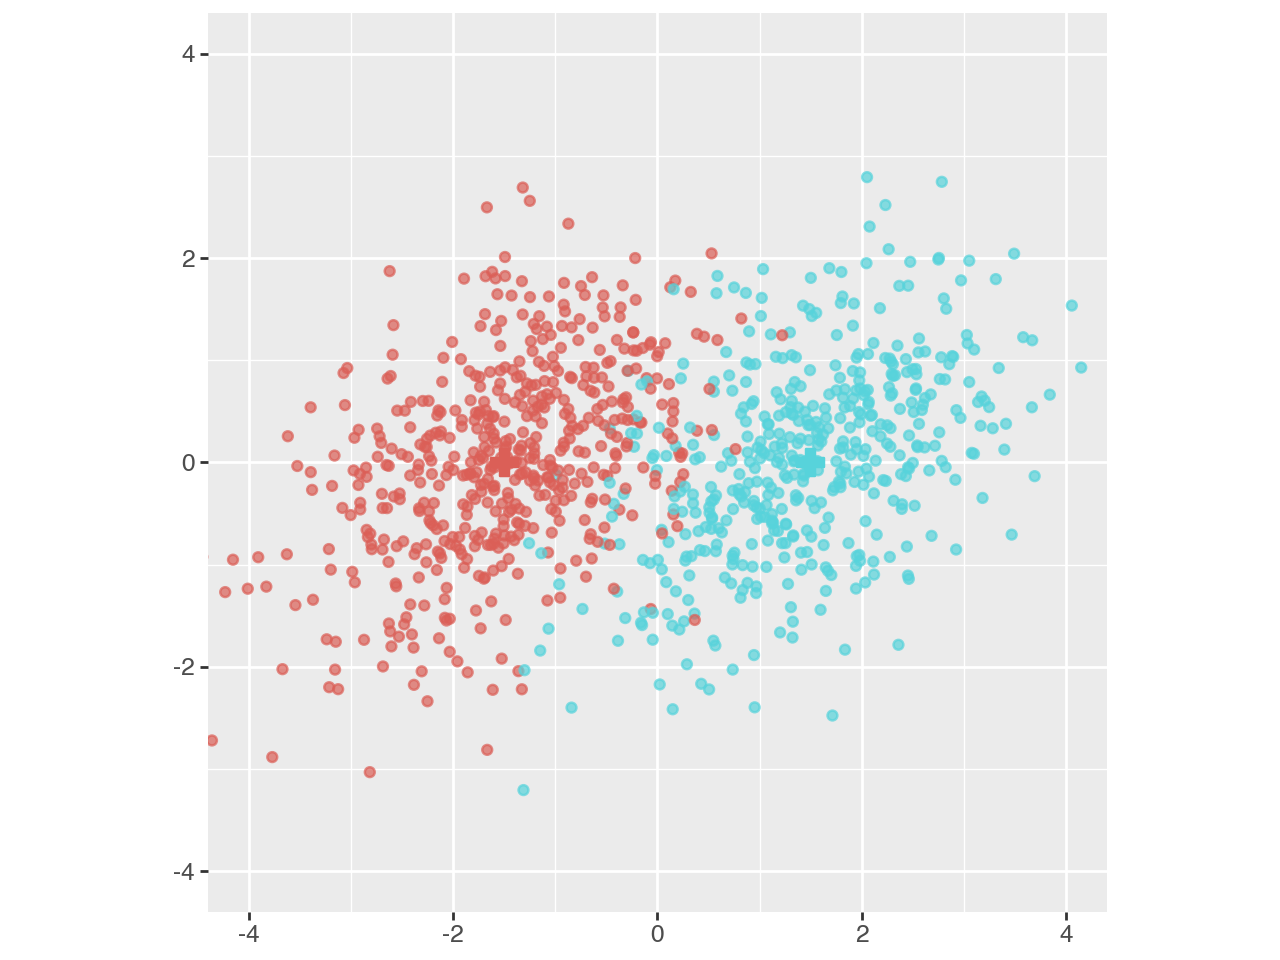

In [17]:
# Dataset size
n = 1000

Sigma = np.array([[1.0, 0.5], [0.5, 1.0]])

# Cluster parameters
Theta = (DataFrame({'x1': [-1.5, 1.5], 'x2': [0.0, 0.0], 
                    'lambda': [0.5, 0.5], 'z': ['A', 'B']})
         .set_index('z', drop=False))

# Dataset generation
df = (DataFrame(multivariate_normal(cov=Sigma).rvs(n),columns=['x1', 'x2'])
      .assign(z = np.random.choice(Theta['z'], p=Theta['lambda'], size = n))
      .assign(x1 = lambda df:  df['x1'] + Theta.loc[df['z'], 'x1'].values)
      .assign(x2 = lambda df:  df['x2'] + Theta.loc[df['z'], 'x2'].values))

mdisplay([Theta,head(df)], ['Model parameters', 'Simulated data'])

p = ggplot(df)
p = p + geom_point(aes(x = 'x1', y = 'x2', color = 'z'), alpha = 0.7)
p = p + geom_point(aes(x = 'x1', y = 'x2', color = 'z'), data = Theta, shape = 'P', fill='black', size=5, )
p = p + scale_color_discrete(name='', guide=None)
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
p = p + coord_fixed(xlim=(-4,4), ylim=(-4,4))
p.save('general_lda_setup_i.pdf', path='results', height=6, width=6, verbose=False)
display(p)

## VII. Projections to one-dimensional subspaces

Let us take four directions $\boldsymbol{w}_1,\ldots,\boldsymbol{w}_4$ onto which we could project the data.
For any direction $\boldsymbol{w}$ the corresponding projections will be $y_i=\boldsymbol{w}^T\boldsymbol{x}_i$. 

### Unit vectors defining projections

,x1,x2
0,0.000000,1.000000
1,1.000000,0.000000
2,-0.707107,0.707107
3,-0.523728,0.851886


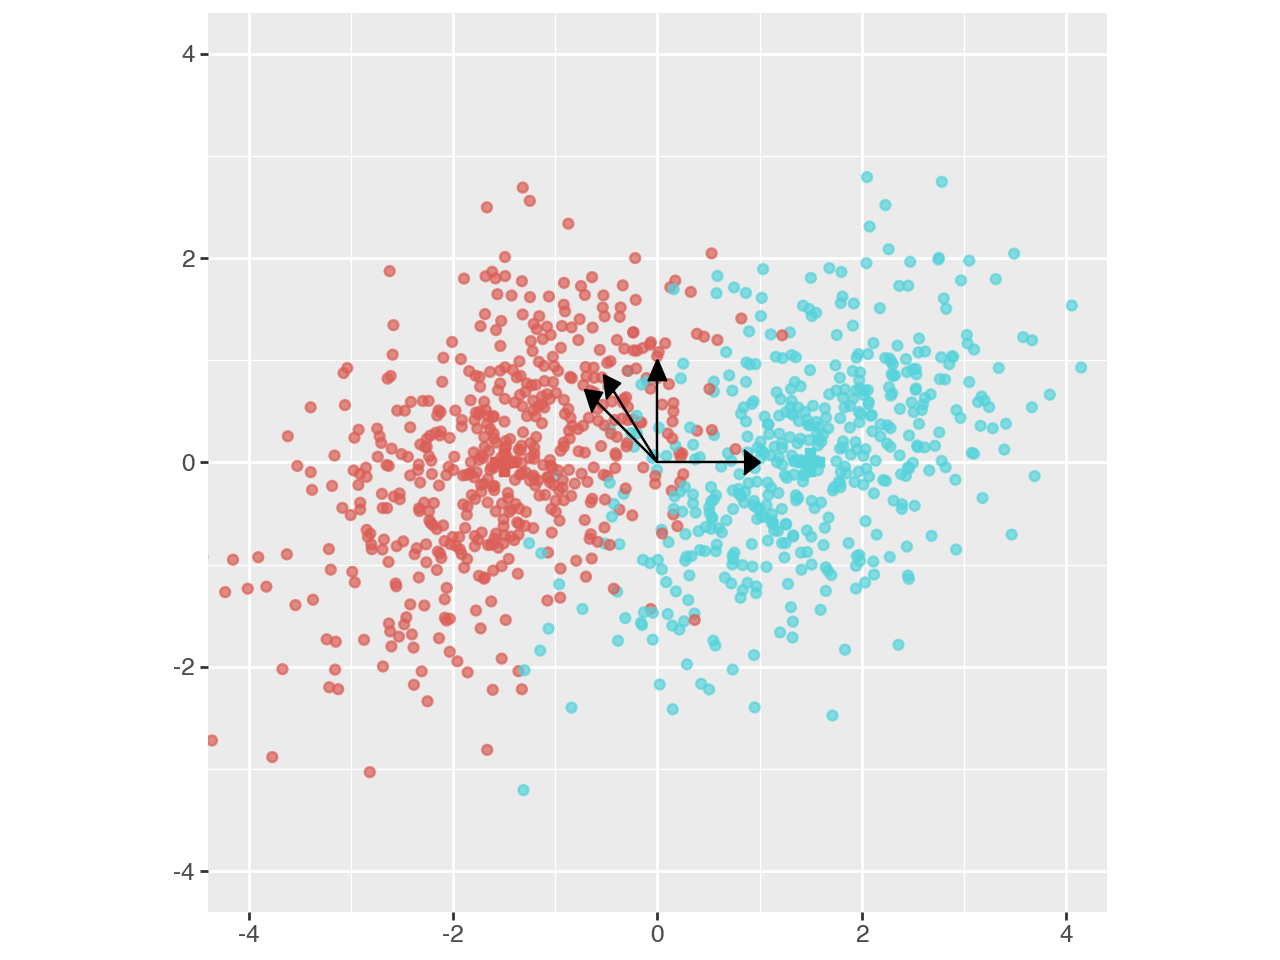

In [18]:
W = (DataFrame([(0,1), (1,0), (-1,1), multivariate_normal(cov=np.identity(2)).rvs(1)], columns = ['x1', 'x2'])
     .assign(d  = lambda df: np.sqrt(df['x1']**2 + df['x2']**2))
     .assign(x1 = lambda df: df['x1']/df['d'])
     .assign(x2 = lambda df: df['x2']/df['d'])
     [['x1','x2']])
     
display(W)

p = ggplot(df)
p = p + geom_point(aes(x = 'x1', y = 'x2', color = 'z'), alpha = 0.7)
p = p + geom_point(aes(x = 'x1', y = 'x2', color = 'z'), data = Theta, shape = 'P', fill='black', size=5, )
p = p + scale_color_discrete(name='', guide=None)
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
p = p + coord_fixed(xlim=(-4,4), ylim=(-4,4))
p = p + geom_segment(aes(xend = 'x1', yend='x2'), data = W, x=0, y=0, arrow=arrow(type = 'closed', length=0.1))
p.save('general_lda_setup_ii.pdf', path='results', height=6, width=6, verbose=False)
display(p)

### Corresponding projections and their visualisations

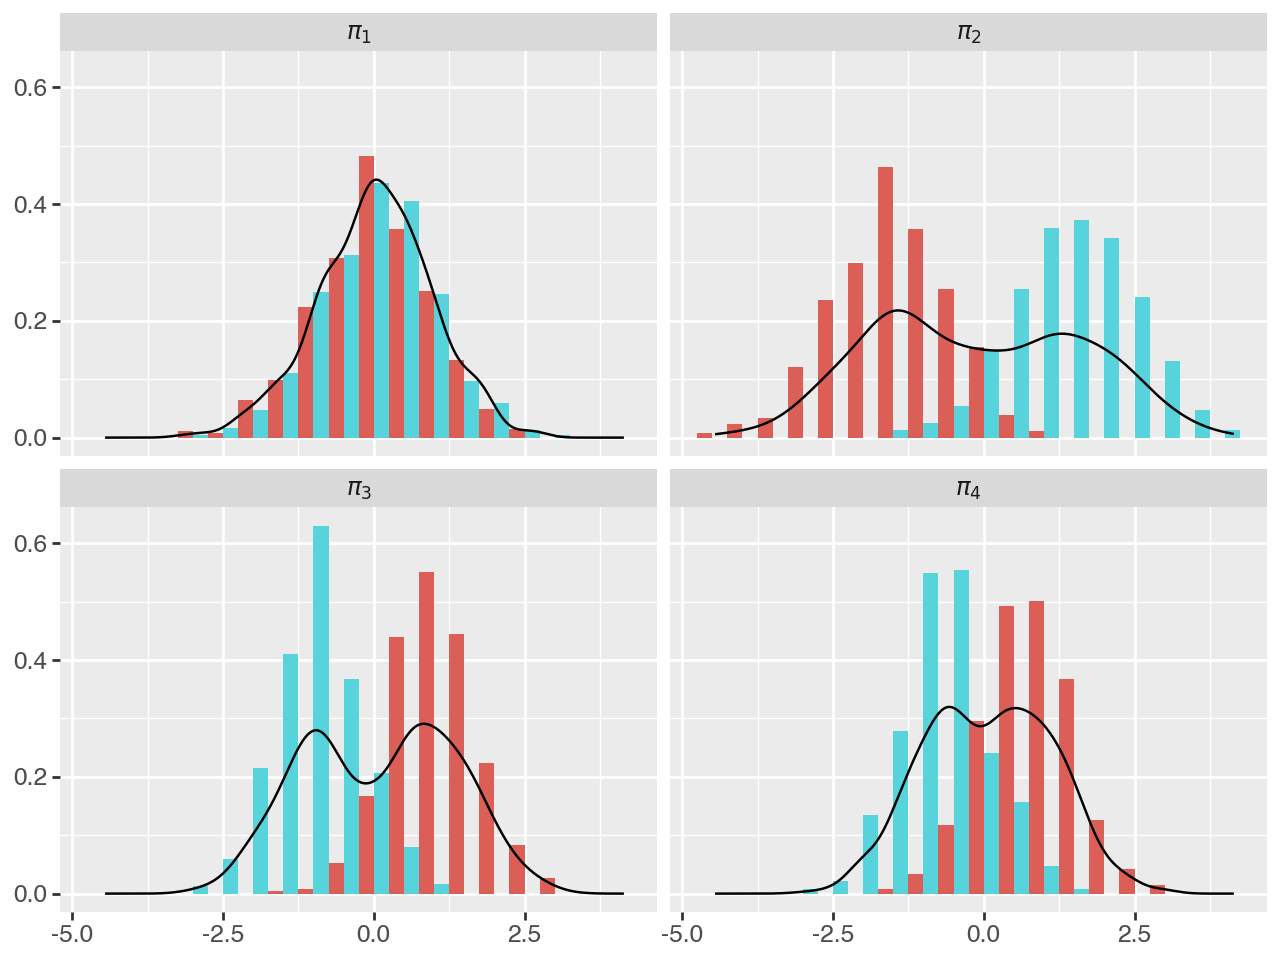

In [19]:
proj = (df[['z']]
      .assign(p1 = df[['x1', 'x2']].dot(W.loc[0, :]))
      .assign(p2 = df[['x1', 'x2']].dot(W.loc[1, :]))
      .assign(p3 = df[['x1', 'x2']].dot(W.loc[2, :]))
      .assign(p4 = df[['x1', 'x2']].dot(W.loc[3, :])))
head(proj)

tmp = (pd.melt(proj, id_vars=['z'], var_name='projector', value_name='y')
       .assign(projector =  lambda df: df['projector'].map(lambda x:'$\pi_{}$'.format(x[1]))))


p = ggplot(tmp)
p = p + geom_histogram(aes(x = 'y', y = '..density..', fill ='z'), binwidth=0.5, position='dodge')
p = p + stat_density(aes(x = 'y'), geom = "line", position = "identity", group = 'z') 
p = p + facet_wrap(['projector'])
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
p = p + scale_fill_discrete(name='', guide=None)
p.save('general_lda_setup_iii.pdf', path='results', height=6, width=12, verbose=False)
display(p)

## VIII. Data whitening transformation

As we know the cluster labels, we can compute maximum likelihood estimates for cluster centers

\begin{align*}
\boldsymbol{\mu}_j=\frac{1}{|\mathcal{I}_j|}\cdot\sum_{i\in\mathcal{I}_j} \boldsymbol{x}_j
\end{align*}

and the covariance matrix shared among clusters aka within-class covariance:

\begin{align*}
\boldsymbol{\Sigma}_W=\frac{1}{n}\cdot\sum_{i=1}^n (\boldsymbol{x}_i-\boldsymbol{\mu}_{z_i})(\boldsymbol{x}_i-\boldsymbol{\mu}_{z_i})^T\,.
\end{align*}

Let the columns of $\boldsymbol{\mathrm W}$ be the orthonormal eigenvectors of $\boldsymbol{\Sigma}_W$:

\begin{align*}
\boldsymbol{\Sigma}_W \boldsymbol{\mathrm W} &= \mathrm{diag}(\boldsymbol{\lambda}) \boldsymbol{\mathrm W}\,,\\
\boldsymbol{\mathrm W}^T\boldsymbol{\mathrm W} &= \boldsymbol{\mathrm I}\,.
\end{align*}

Then we can define an invertible matrix 

\begin{align*}
\boldsymbol{\mathrm{A}} =  \mathrm{diag}\bigl(\boldsymbol{\lambda}^{-1/2}\bigr)\boldsymbol{\mathrm{W}}^T 
\end{align*}

such that


\begin{align*}
\boldsymbol{\mathrm{A}}\boldsymbol{\Sigma}_w\boldsymbol{\mathrm{A}}^T=
\mathrm{diag}\bigl(\boldsymbol{\lambda}^{-1/2}\bigr)\boldsymbol{\mathrm{W}}^T 
\boldsymbol{\Sigma}_w 
\boldsymbol{\mathrm{W}} \mathrm{diag}\bigl(\boldsymbol{\lambda}^{-1/2}\bigr)=
\mathrm{diag}\bigl(\boldsymbol{\lambda}^{-1/2}\bigr)
\mathrm{diag}\bigl(\boldsymbol{\lambda}\bigl)
\mathrm{diag}\bigl(\boldsymbol{\lambda}^{-1/2}\bigr)=
\boldsymbol{\mathrm{I}}\,.
\end{align*}

As a result, if we define a transformation

\begin{align*}
\boldsymbol{x}_1^*=\boldsymbol{\mathrm{A}}\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n^*=\boldsymbol{\mathrm{A}}\boldsymbol{x}_n
\end{align*}

then the maximum likelihood estimate for the covariance matrix for $\boldsymbol{x}_1^*,\ldots,\boldsymbol{x}_n^*$ is the identity matrix $\boldsymbol{\mathrm I}$ and we are back in the setting with spherical normal distributions.  

### Inverse square root of a symmetric matrix

In [20]:
def matrix_invsqrt(Sigma: np.array) -> np.array:
    """
    Finds inverse square root of a matrix: A^T * A = Sigma^(-1)
    """

    assert all(Sigma == Sigma.T), 'Matrix must be symmetric'
        
    Lambda, W = np.linalg.eigh(Sigma)
    return np.dot(np.diag(Lambda**(-0.5)), W.T)        

### Whitening transformation

In [21]:
# Group extraction
XA = df.loc[df['z'] == 'A', ['x1', 'x2']]
XB = df.loc[df['z'] == 'B', ['x1', 'x2']]

# Data centering
XA = XA.transform(lambda x: x - np.mean(x))
XB = XB.transform(lambda x: x - np.mean(x))

# Covariance computation
Sigma_W = (XA.T.dot(XA) + XB.T.dot(XB))/len(df)
A = DataFrame(matrix_invsqrt(Sigma_W), columns = ['x1', 'x2'], index = ['xx1', 'xx2'])

# Data transformation
sdf = A.dot(df[['x1','x2']].T).T.assign(z = df['z'])

# Transformation of directions
Wx = A.dot(W.T).T

mdisplay([Sigma_W, A, head(sdf), Wx], ['Covariance matrix $\Sigma_W$', 'Scaling matrix', 'Result', 'Directions'])

Covariance matrix $\Sigma_W$ Scaling matrix Result Directions 
 
 
 x1 
 x2 
 
 
 
 
 0.951170 
 0.424104 
 
 
 0.424104 
 0.908381 
 
 
 
 
 
 x1 
 x2 
 
 
 
 
 0.969520 
 -1.019661 
 
 
 -0.622705 
 -0.592084 
 
 
 
 
 
 xx1 
 xx2 
 z 
 
 
 
 
 -0.909229 
 -0.985595 
 A 
 
 
 1.334951 
 0.224662 
 B 
 
 
 -2.284773 
 -0.088352 
 A 
 
 
 0.264626 
 -0.503434 
 B 
 
 
 0.944997 
 -3.068871 
 B 
 
 
 
 
 
 xx1 
 xx2 
 
 
 
 
 -1.019661 
 -0.592084 
 
 
 0.969520 
 -0.622705 
 
 
 -1.406563 
 0.021653 
 
 
 -1.376399 
 -0.178260

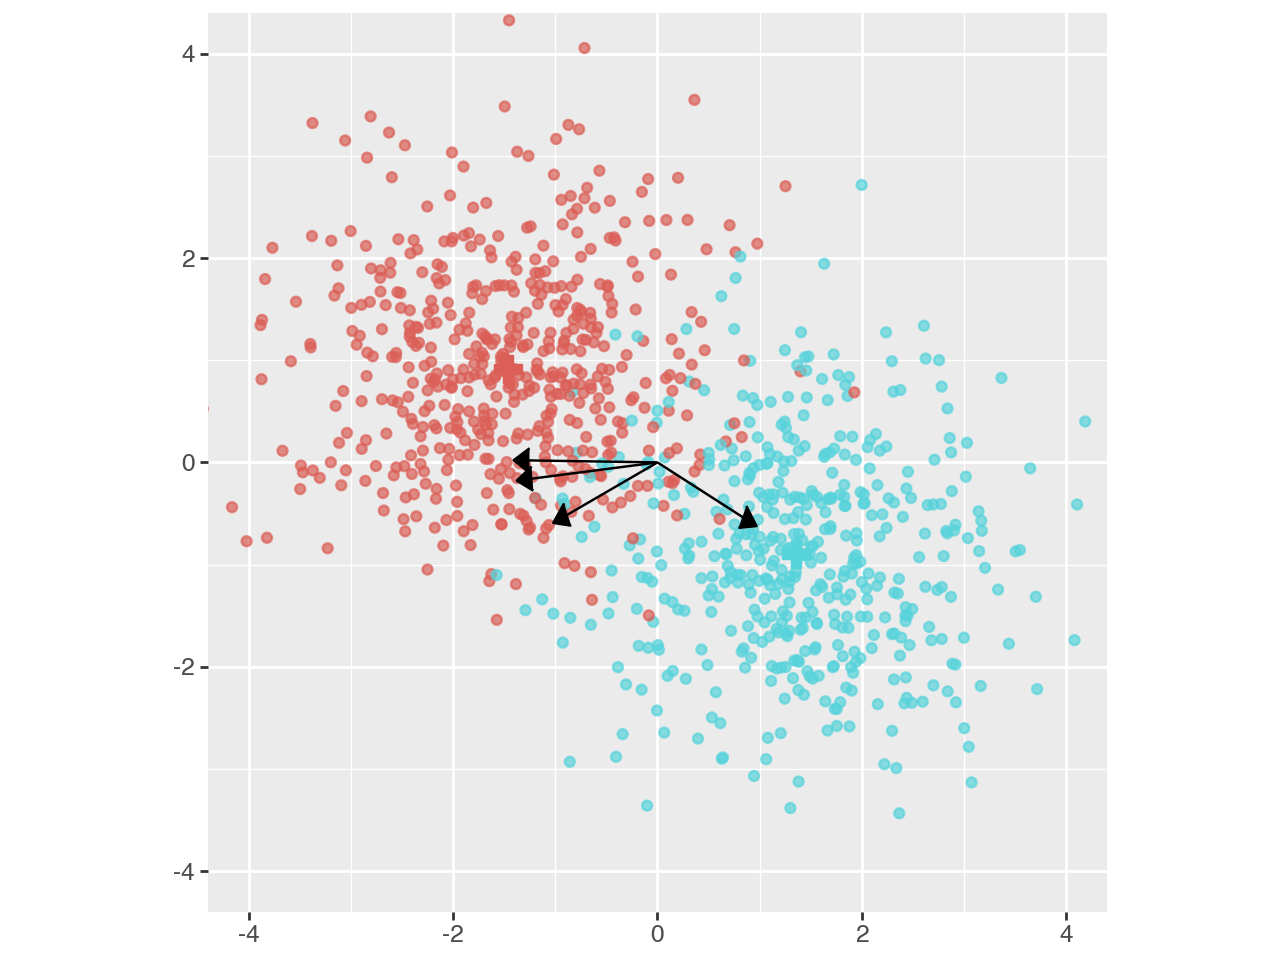

In [22]:
p = ggplot(sdf)
p = p + geom_point(aes(x = 'xx1', y = 'xx2', color = 'z'), alpha = 0.7)
p = p + geom_point(aes(x = 'xx1', y = 'xx2', color = 'z'), data = sdf.groupby('z').mean().reset_index(), shape = 'P', fill='black', size=5, )
p = p + scale_color_discrete(name='', guide=None)
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
p = p + coord_fixed(xlim=(-4,4), ylim=(-4,4))
p = p + geom_segment(aes(xend = 'xx1', yend='xx2'), data = Wx, x=0, y=0, arrow=arrow(type = 'closed', length=0.1))
p.save('general_lda_setup_iv.pdf', path='results', height=6, width=6, verbose=False)
display(p)

## IX. Closed form solution for the maximisation task


As $\boldsymbol{x}_1^*=\boldsymbol{\mathrm{A}}\boldsymbol{x}_1,\ldots, \boldsymbol{x}_n^*=\boldsymbol{\mathrm{A}}\boldsymbol{x}_n$ have spherical normal distributions, we can solve the maximisation task using the between-class scatter matrix $\boldsymbol{\mathrm S}_B^*$.
However, the matrix must be computed in terms of the transformed datapoints $\boldsymbol{x}_1^*,\ldots,\boldsymbol{x}_n^*$ and their means $\boldsymbol{\mu}^*,\boldsymbol{\mu}_1^*,\ldots,\boldsymbol{\mu}_\ell^*$: 

\begin{align*}
\boldsymbol{\mathrm{S}}_B^*
&=\sum_{i=1}^n(\boldsymbol{\mu}_{z_i}^*-\boldsymbol{\mu}^*)
(\boldsymbol{\mu}_{z_i}^*-\boldsymbol{\mu}^*)^T \\
&=\sum_{i=1}^n(\boldsymbol{\mathrm{A}}\boldsymbol{\mu}_{z_i}-\boldsymbol{\mathrm{A}}\boldsymbol{\mu})
(\boldsymbol{\mathrm{A}}\boldsymbol{\mu}_{z_i}-\boldsymbol{\mathrm{A}}\boldsymbol{\mu})^T \\
&=\boldsymbol{\mathrm{A}}\Biggl(\sum_{i=1}^n(\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})
(\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})^T\Biggr)\boldsymbol{\mathrm{A}}^T\\
&=
\boldsymbol{\mathrm{A}}S_B\boldsymbol{\mathrm{A}}^T\,.
\end{align*}

After that we can solve the maximisation task in the transformed space as

\begin{align*}
\sum_{j=1}^k {\boldsymbol{w}_j^*}^T\boldsymbol{\mathrm S}_B^*\boldsymbol{w}_j^* \to \max\\
\text{s.t. }{\boldsymbol{w}_i^*}^T\boldsymbol{w}_j^*=\delta_{i,j}
\end{align*}

by finding the eigenvectors $\boldsymbol{w}_1,\ldots,\boldsymbol{w}_m$ of $\boldsymbol{\mathrm S}_B^*$ with corresponding eigenvalues $\lambda_1\geq \ldots\geq\lambda_m$. 
The sum is maximised only if we take the first $k$ eigenvectors.

# Homework 

## 5.1 Implement LDA algorithm (<font color='red'>2p</font>)

Implement LDA algorithm as a function for three-dimensional case. First, implement the algorithm for the spherical normal distribution and test it with cluster centres placed on symmetrical positions on the $xy$-plane:

\begin{align*}
\boldsymbol{\mu}_1&=(1,0,0)\,,\\
\boldsymbol{\mu}_2&=(\sin(\pi/3),\cos(\pi/3),0)\,,\\
\boldsymbol{\mu}_2&=(\sin(\pi/3),-\cos(\pi/3),0)\,.\\
\end{align*}

Use the shared covariance matrix $\boldsymbol{\mathrm I}$. Compute the amount of variance covered by the LDA components, that is the plane fixed by $\boldsymbol{w}_1$ and $\boldsymbol{w}_2$. For the example above, the LDA projection selects the $xy$-plane and you must compute the summary variance of the first two coordinates.

Second, implement the whitening transformation and compute the solution for the transformed data $\boldsymbol{w}_1^*$ and $\boldsymbol{w}_2^*$. After that translate this back to the original space, i.e., compute $\boldsymbol{w}_1$ and $\boldsymbol{w}_2$. Again, compute the amount of variance covered by the LDA components – the plane fixed by $\boldsymbol{w}_1$ and $\boldsymbol{w}_2$ – and compare with the entire variance of the data. To test the function use any non-trivial affine transformation to map the test configuration specified above into a non-spherical test configuration.  